# Neuroscope
Generating horoscope-like tweets with different implementations of RNN

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import twitter as twt
import seaborn as sns
import codecs as cdc
import pickle
import nltk
import pymorphy2
import itertools
import string
import os
import re
import random as rnd
from collections import Counter, deque
from sklearn.manifold import TSNE, MDS

sns.set_style('whitegrid')
sns.despine()

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Acquire corpus
---
Initialize Twitter client

In [ ]:
API_KEY = os.environ.get('TWITTER_API_KEY', '')
API_SECRET = os.environ.get('TWITTER_API_SECRET', '')
BEARER_TOKEN = twt.oauth2_dance(API_KEY, API_SECRET)
t = twt.Twitter(auth=twt.OAuth2(bearer_token=BEARER_TOKEN))

Download data

In [2]:
accounts = np.array(['gor_aries', 'gor_taurus', 'gor_gemini', 'gor_cancer', 'gor_leo', 'gor_virgo', \
                     'gor_libra', 'gor_scorpio', 'gor_sagittarius', 'gor_aquarius', \
                     'gor_pisces', 'aries_astro7', 'taurus_astro7', 'gemini_astro7', 'cancer_astro7',
                     'leo_astro7', 'virgo_astro7', 'libra_astro7', 'scorpio_astro7', 'kozerog_astro7',
                     'aquaris_astro7', 'pisces_astro7'])
months = np.array([u'января', u'февраля', u'марта', u'апреля', u'мая', u'июня', u'июля', u'августа', u'сентрября', \
                   u'октября', u'ноября', u'декабря'])

In [3]:
def download_data(accounts, filename='raw'):
    print 'Downloading data'
    raw = []

    for account in accounts:
        print '-> Processing account %s' % account
        max_id = 0
        tweets = []

        if not os.path.isfile('./raw_%s' % account):
            print '--> Receiving tweets'
            part = t.statuses.user_timeline(screen_name=account, include_rts='false', exclude_replies='true')
            for tweet in part:
                tweets.append(tweet)
            old_max_id = max_id
            max_id = tweets[len(tweets)-1]['id']

            while old_max_id != max_id:
                part = t.statuses.user_timeline(screen_name=account, 
                                                include_rts='false', exclude_replies='true', max_id=max_id, timeout=1)
                for tweet in part:
                    tweets.append(tweet)
                old_max_id = max_id
                max_id = tweets[len(tweets)-1]['id']
            print '--> Received %d tweets' % len(tweets)

            with open('raw_%s' % account, 'w') as fout:
                pickle.dump(tweets, fout)
            print '--> Dumped tweets'
        else:
            with open('raw_%s' % account, 'r') as fin:
                tweets = pickle.load(fin)
            print '--> Loaded previously dumped %d tweets' % len(tweets)
        
        tweets = [tweet['text'] for tweet in tweets]
        for tweet in tweets:
            raw.append(tweet)
        del tweets

    with open(filename, 'w') as fout:
        pickle.dump(raw, fout)
    del raw
    
def pad_data(data, pad_to=None, pad_with='<p>'):
    if pad_to is None:
        pad_to = max([len(item) for item in data])
    
    padded = []
    for item in data:
        amount = pad_to - len(item)
        if amount < 0:
            padded.append(item[:amount])
        else:
            padded.append(item + [pad_with] * amount)
            
    return padded

def array_equals(a, b):
    if len(a) != len(b):
        return False
    else:
        length = len(a)
        for i in range(length):
            if a[i] != b[i]:
                return False
            
    return True

def clean_up(tokenized):
    print '-> Cleaning up data'
    
    cleaned = []
    
    cleaned.append(tokenized[0])
    length = 1
    
    for i in range(1, len(tokenized)):
        j = 0
        
        while j < length:
            if array_equals(tokenized[i], cleaned[j]):
                break
            j += 1
        
        if j == length:
            cleaned.append(tokenized[i])
            length += 1
                
    return cleaned

def load_data(filename='./raw', load=False):
    print 'Reading data'
    
    tokenized = []
    words = []
    
    if not load:
        print '-> With preprocesing'
        with open(filename, 'r') as fin:
            tweets = pickle.load(fin)

        morph = pymorphy2.MorphAnalyzer()

        for tweet in tweets:
            result = [u'<$>']
            tweet = nltk.word_tokenize(tweet.lower())
            tweet = [w for w in tweet if w not in string.punctuation]
            tweet = [w for w in tweet if re.compile(u'[а-я]*').match(w).end() == len(w)]
            tweet = [w for w in tweet if w not in months]
            tweet = [morph.parse(w)[0].normal_form for w in tweet]
            tweet.append(u'<#>')
            result.extend(tweet)
            tokenized.append(result)
            
        print '--> Before cleanup %d tweets' % len(tokenized)
        tokenized = clean_up(tokenized)
        tokenized = pad_data(tokenized)
        print '--> After cleanup %d tweets' % len(tokenized)
        words = np.concatenate(tokenized)

        with open('tokenized', 'w') as fout:
            pickle.dump(tokenized, fout)
            
        with open('words', 'w') as fout:
            pickle.dump(words, fout)
    else:
        print '-> Previously processed'
        with open('tokenized', 'r') as fin:
            tokenized = pickle.load(fin)
            
        with open('words', 'r') as fin:
            words = pickle.load(fin)
            
        print '--> Found %d tweets, %d tokens' % (len(tokenized), len(words))
    
    return tokenized, words

def build_dataset(dataset, words, vocabulary_size=None):
    word_to_index = {}
    index_to_word = {}
    word_count = []
    tokenized = []
    data = []
    
    word_count.extend(Counter(words).most_common(vocabulary_size))
    print 'Most common word is %s with %d times' % (word_count[0][0], word_count[0][1])
    print 'Least common word is %s with %d times' % (word_count[len(word_count)-1][0],
                                                     word_count[len(word_count)-1][1])
    
    for word, _ in word_count:
        word_to_index[word] = len(word_to_index)
    
    for item in dataset:
        tmp = []
        for word in item:
            index = word_to_index[word]
            tmp.append(index)
            data.append(index)
        tokenized.append(tmp)
    
    index_to_word = dict(zip(word_to_index.values(), word_to_index.keys()))
    data = [word_to_index[w] for w in words]
    
    return tokenized, data, word_count, word_to_index, index_to_word

In [4]:
# download_data(accounts)
tweets, words = load_data(load=True)

Reading data
-> Previously processed
--> Found 10641 tweets, 308589 tokens


In [5]:
tokenized, data, word_count, word_to_index, index_to_word = build_dataset(tweets, words)
vocabulary_size = len(word_count)
print 'Using vocabulary size %d' % vocabulary_size

Most common word is <p> with 140492 times
Least common word is выступить with 1 times
Using vocabulary size 7945


LSTM
---

In [13]:
class DataLoader(object):
    def __init__(self, tweets, batch_size, horizon):
        self._tweets = tweets
        self._num_tweets = len(tweets)
        self._tweet_len = len(tweets[0])
        self._batch_size = batch_size
        self._horizon = horizon
        self._tweets_idx = self._get_tweets_idx(self._batch_size)
        self._cursor = 0
        self._last_batch = self._next_batch()
        self._cursor = 1
        
    def _get_tweets_idx(self, count):
        idx = np.random.choice(self._num_tweets, count)
        return idx
  
    def _next_batch(self):
        """Generate a single batch from the current cursor position in the data."""
        batch = np.zeros(shape=(self._batch_size), dtype=np.int32)
        for b in range(self._batch_size):
            batch[b] = self._tweets[self._tweets_idx[b]][self._cursor]
        return batch
  
    def next(self):
        """Generate the next array of batches from the data. The array consists of
        the last batch of the previous array, followed by num_unrollings new ones.
        """
        batches = np.zeros(shape=(self._horizon + 1, self._batch_size), dtype=np.int32)
        batches[0] = self._last_batch
        for step in range(self._horizon):
            batches[step + 1] = self._next_batch()
            self._cursor += 1
            if self._cursor % self._tweet_len == 0:
                self._cursor = 0
                self._tweets_idx = self._get_tweets_idx(self._batch_size)
                break
        self._last_batch = batches[-1]
        return batches

def logprob(predictions, labels):
    true = np.zeros_like(predictions, dtype=np.float)
    for i in range(len(labels)):
        true[i, labels[i]] = 1.0
    predictions[predictions < 1e-10] = 1e-10
    return np.sum(np.multiply(true, -np.log(predictions))) / true.shape[0]

def perplexity(predictions, labels):
    return np.exp(logprob(predictions, labels))

def sample(distribution):
    r = rnd.uniform(0, 1)
    s = 0
    
    for i in range(len(distribution)):
        s += distribution[i]
        if s >= r:
            return i
    
    return len(distribution) - 1

In [24]:
valid_pct = 0.1
valid_size = int(len(tokenized) * valid_pct)
trunc_by = 30
batch_size = 128
num_nodes = 256
embedding_size = 256
valid_dataset = tokenized[:valid_size]
train_dataset = tokenized[valid_size:]

train_batches = DataLoader(train_dataset, batch_size, trunc_by)
valid_batches = DataLoader(valid_dataset, 1, 1)

Loss function:
$$\mathcal{L} = - \sum\limits_{k = 1}^N y_k \log o_k$$

Output at step $k$:
$$o_k = softmax(H_k \ast W_{(sm)}^k + b_{(sm)}^k) = \frac{\exp \{H_k \ast W_{(sm)}^k + b_{(sm)}^k\}}{\sum\limits_{n=1}^N \exp \{H_n \ast W_{(sm)}^n + b_{(sm)}^n\}}$$

Hidden state at step $k$:
$$H_k = output\_gate(w_k, H_{k-1}) \cdot \tanh (state_k \ast W_{(h)} + b_{(h)})$$

Cell state at step $k$:
$$state_k = forget\_gate \cdot state_{k-1} + input\_gate \cdot \tanh ([w_k, h_{k-1}] \ast W_{(c)} + b_{(c)})$$

Output gate function for step $k$:
$$output\_gate(w_k, H_{k-1}) = \sigma([w_k, h_{k-1}] W_{(o)} + b_{(o)})$$

Forget gate function for step $k$:
$$forget\_gate(w_k, H_{k-1}) = \sigma([w_k, h_{k-1}] W_{(f)} + b_{(f)})$$

Input gate function for step $k$:
$$output\_gate(w_k, H_{k-1}) = \sigma([w_k, h_{k-1}] W_{(i)} + b_{(i)})$$

In [25]:
graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    # Input data
    train_data = [tf.placeholder(tf.int32, shape=[batch_size]) for i in range(trunc_by+1)]
    train_inputs = train_data[:-1]
    train_labels = train_data[1:]

    # Variables
    # Embedding
    embeddings = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], -0.1, 0.1), name='embeddings')
    # The big matrix
    Tw = tf.Variable(tf.truncated_normal([embedding_size + num_nodes, 4 * num_nodes], -0.1, 0.1))
    Tb = tf.Variable(tf.zeros([1, 4 * num_nodes]))
    # Connections
    saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]),
                              name='saved_output')
    saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]),
                          name='saved_state')
    # Softmax
    softmax_weights = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size]),
                                  name='softmax_weights')
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]),
                                 name='softmax_biases')
    
    # Cell
    def lstm_cell(i, state, cell):
        i = tf.concat([i, state], 1)
        tmp = tf.matmul(i, Tw) + Tb

        inputs_gate = tf.sigmoid(tmp[:, :num_nodes])
        forget_gate = tf.sigmoid(tmp[:, num_nodes:2*num_nodes])
        output_gate = tf.sigmoid(tmp[:, 2*num_nodes:3*num_nodes])
        update_gate = tf.tanh(tmp[:, 3*num_nodes:])

        cell = forget_gate * cell + inputs_gate * update_gate
        state = output_gate * tf.tanh(cell)
        return state, cell

    # Model
    outputs = []
    output = saved_output
    state = saved_state
    for w in train_inputs:
        e = tf.nn.embedding_lookup(embeddings, w)
        output, state = lstm_cell(e, output, state)
        outputs.append(output)
        
    with tf.control_dependencies([saved_output.assign(output), saved_state.assign(state)]):
        sparse_outputs = tf.nn.dropout(tf.concat(outputs, 0), keep_prob=0.5)
        logits = tf.nn.xw_plus_b(sparse_outputs, softmax_weights, softmax_biases)
        true = tf.one_hot(indices=tf.concat(train_labels, 0), depth=vocabulary_size)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.concat(true, 0), logits=logits)
                              + 0.01 * tf.nn.l2_loss(Tw) + 0.01 * tf.nn.l2_loss(Tb))
    # State resetting
    reset_state = tf.group(saved_state.assign(tf.zeros([batch_size, num_nodes])))
    tf.add_to_collection('ops', reset_state)
    
    # Optimizer
    gs = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(1e-2, gs, 3000, 0.1, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    
    # Gradients
    gradients, v = zip(*optimizer.compute_gradients(loss))
    gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
    optimizer = optimizer.apply_gradients(zip(gradients, v), global_step=gs)

    # Prediction
    train_prediction = tf.nn.softmax(tf.nn.xw_plus_b(tf.nn.dropout(tf.concat(outputs, 0), keep_prob=0.5),
                                                     softmax_weights, softmax_biases))
    
    # Evaluation
    sample_input = tf.placeholder(tf.int32, [1])
    saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]), name='saved_sample_output')
    saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]), name='saved_sample_state')
    
    sample_embedding = tf.nn.embedding_lookup(embeddings, sample_input)
    reset_sample_state = tf.group(saved_sample_output.assign(tf.zeros([1, num_nodes])),
                                  saved_sample_state.assign(tf.zeros([1, num_nodes])))
    
    tf.add_to_collection('ops', reset_sample_state)
    
    sample_output, sample_state = lstm_cell(sample_embedding, saved_sample_output, saved_sample_state)
    with tf.control_dependencies([saved_sample_output.assign(sample_output), saved_sample_state.assign(sample_state)]):
        sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, softmax_weights, softmax_biases))
        tf.add_to_collection('ops', sample_prediction)
        
    # Saving
    to_save = {'Tw': Tw, 'Tb': Tb, 'saved_state': saved_state, 'saved_output': saved_output,
               'softmax_weights': softmax_weights, 'softmax_biases': softmax_biases,
               'saved_sample_output': saved_sample_output, 'saved_sample_state': saved_sample_state,
               'embeddings': embeddings}
    
    saver = tf.train.Saver(to_save)

In [26]:
num_steps = 20001
print_every = 500
losses = []

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    
    average_loss = 0
    for step in range(num_steps):
        batches = train_batches.next()
        labels = np.concatenate(batches[1:])
        feed_dict = {}
        for i in range(trunc_by + 1):
            feed_dict[train_data[i]] = batches[i]

        opt, l, pred, lr = session.run([optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
        average_loss += l
        if step % print_every == 0:
            if step > 0:
                average_loss = average_loss / print_every
            losses.append(average_loss)
            print 'Average loss at step %d: %.2f learning rate %e' % (step, average_loss, lr)
            average_loss = 0
            labels = np.concatenate(batches[1:])
            print 'Minibatch perplexity: %e' % perplexity(pred, labels)
                  
            if (step % (print_every * 5)) == 0:
                sym = word_to_index['<$>']
                reset_sample_state.run()
                iter_num = 0
                tweet = []
                while sym != word_to_index['<#>'] and iter_num < 40:
                    prediction = sample_prediction.eval({sample_input: np.array([sym])})[0]
                    prediction = sample(prediction)
                    if prediction == word_to_index['<$>']:
                        break
                    tweet.append(index_to_word[prediction])
                    sym = prediction
                    iter_num += 1
                print '=' * 98
                print ' '.join(tweet[:-1])
                print '=' * 98
                
                saver.save(session, './Model2/model')
            
            reset_sample_state.run()
            valid_logprob = 0
            for _ in range(valid_size):
                b = valid_batches.next()
                predictions = sample_prediction.eval({sample_input: b[0]})
                valid_logprob = valid_logprob + logprob(predictions, b[1])
            print 'Validation set perplexity: %e\n' % np.exp(valid_logprob / valid_size)
            if len(losses) > 2 and abs(losses[-2] - losses[-1]) < 1e-3:
                print 'Converged'
                break
        if array_equals(batches[-1], np.zeros_like(batches[0])):
            reset_state.run()

Initialized
Average loss at step 0: 77.90 learning rate 1.000000e-02
Minibatch perplexity: 8.697712e+06
значит болезненно значит защитник значит приземлиться значит подлизываться значит увезти значит запрещать значит помечтать значит потеплеть значит выдохнуть значит сообразовываться значит соваться значит нигде значит умалчивать значит естественность значит поселиться значит утренний значит простота значит сжечь значит курс значит
Validation set perplexity: 6.985936e+06

Average loss at step 500: 4.10 learning rate 1.000000e-02
Minibatch perplexity: 1.135128e+01
Validation set perplexity: 4.030215e+01

Average loss at step 1000: 2.53 learning rate 1.000000e-02
Minibatch perplexity: 8.020035e+00
Validation set perplexity: 3.035326e+01

Average loss at step 1500: 2.27 learning rate 1.000000e-02
Minibatch perplexity: 5.417690e+00
Validation set perplexity: 3.244524e+01

Average loss at step 2000: 2.14 learning rate 1.000000e-02
Minibatch perplexity: 6.760558e+00
Validation set perplexity

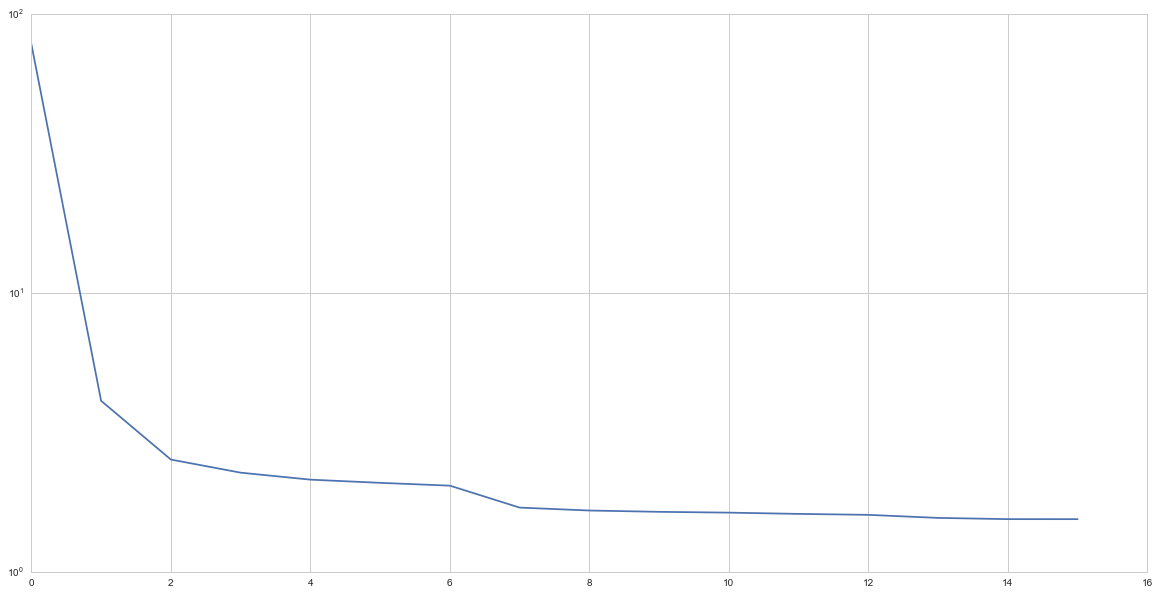

In [27]:
plt.figure(figsize=(20, 10))
plt.semilogy(losses)

Restore model to make new predictions

In [42]:
with tf.Session(graph=graph) as session:
    loader = tf.train.import_meta_graph('./Model2/model.meta')
    loader.restore(session, './Model2/model')
    
    ops = tf.get_collection('ops')
    reset_state = ops[0]
    reset_sample_state = ops[1]
    sample_prediction = ops[2]
    
    for _ in range(5):
        sym = word_to_index['<$>']
        reset_sample_state.run(session=session)
        iter_num = 0
        tweet = []
        while sym != word_to_index['<#>'] and iter_num < 40:
            prediction = sample_prediction.eval({sample_input: np.array([sym])}, session)[0]
            prediction[word_to_index['<#>']] *= ((1 + iter_num) / (1 + 10)) ** 0.005
            prediction = sample(prediction)
            if prediction == word_to_index['<$>']:
                break
            tweet.append(index_to_word[prediction])
            sym = prediction
            iter_num += 1
        print '--> %s' % ' '.join(tweet[:-1])

--> сентябрь вы сегодня прекрасный новое сходу осознать что жизнь мочь не быть так что не хотеть
--> готовиться к о это очень высокий позитивный и эмоция в нежный
--> вчера спокойный пятница не далеко не держаться нахрен выступить соло подобрать место и проблема
--> дева недовольный пока не сдохнуть предыдущий отдых как выделываться и
--> весы большой не хватать машина деньга на близнец для львов если это человек где ручка и быть
